# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

<div class="span5 alert alert-info">
### Exercises
You will perform a statistical analysis to establish whether race has a significant impact on the rate of callbacks for resumes.

Answer the following questions **in this notebook below and submit to your Github account**. 

   1. What test is appropriate for this problem? Does CLT apply?
   2. What are the null and alternate hypotheses?
   3. Compute margin of error, confidence interval, and p-value. Try using both the bootstrapping and the frequentist statistical approaches.
   4. Write a story describing the statistical significance in the context or the original problem.
   5. Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

You can include written notes in notebook cells using Markdown: 
   - In the control panel at the top, choose Cell > Cell Type > Markdown
   - Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet


#### Resources
+ Experiment information and data source: http://www.povertyactionlab.org/evaluation/discrimination-job-market-united-states
+ Scipy statistical methods: http://docs.scipy.org/doc/scipy/reference/stats.html 
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
+ Formulas for the Bernoulli distribution: https://en.wikipedia.org/wiki/Bernoulli_distribution
</div>
****

In [90]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [4]:
# number of callbacks for black-sounding names
sum(data[data.race=='b'].call)

157.0

In [5]:
# number of callbacks for white-sounding names
sum(data[data.race=='w'].call)

235.0

## Q1

In [91]:
data.head(2)

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,


In [6]:
n = len(data)
n

4870

<div class="span5 alert alert-success">
<p>The Null Hypothesis Significance Test (NHST) is suitable for this problem. Specifically, a two-sample two-tailed test will be performed. The Central Limit Theorem (CLT) states that as the sample size n grows, the distribution of $\overline{X}_n$ converges to the normal distribution $N(μ,σ^2/n)$. The sample size n does not need to be very large for the CLT to apply, usually n > 30 is sufficient. In our case, n = 4870, so CLT applies.</p>
</div>

## Q2

<div class="span5 alert alert-success">
<p> **Null and alternative hypotheses** </p>

<p>$H_o$: resume has equal chance of being called regardless of white-sounding or black-sounding names. </p>
<p>$H_A$: resume call is different between white-sounding or black-sounding names. </p>

</div>

## Q3
Compute margin of error, confidence interval, and p-value.

In [7]:
w = data[data.race=='w']
b = data[data.race=='b']

In [8]:
# The proportion of resumes being called for our sample data
theta = sum(data.call)/n
print("%.4f" % theta)

0.0805


<div class="span5 alert alert-success">
<p> **Refine the null and alternative hypotheses** </p>

Let $\theta$ be the proportion of resumes being called:
<p>$H_o$: $\theta_b = \theta_w$ </p>
<p>$H_A$: $\theta_b\neq\theta_w$ </p>

<p>Set the significance level $\alpha$ to be 0.05. </p>

</div>

__Bootstrap approach__

Take the original data of "b" and "w", concatenate them and scramble the entries, then take the first n1 entries as "b" and last n2 entries as "w". Calculate the fraction of entries with black-sounding names from this scrambled sample, and compare with the original dataset. 

In [9]:
# number of callbacks for black-sounding names
b_yes = int(sum(b.call))
b_no = int(len(b) - b_yes)

# number of callbacks for white-sounding names
w_yes = int(sum(w.call))
w_no = int(len(w) - w_yes)

In [10]:
# Calculate theta_b and theta_w
theta_b = sum(b.call)/len(b)
theta_w = sum(w.call)/len(w)
theta_diff = theta_b - theta_w
theta_diff

-0.032032854209445585

In [11]:
# Generate a permutation sample of two arrays having respectively n1 and n2 entries. Constructed by concatenating the 
# arrays together, scrambling the contents of the concatenated array, and then taking the first n1 entries as the 
# permutation sample of the first array and the last n2 entries as the permutation sample of the second array.
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""

    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [12]:
def draw_perm_reps(black, white, size=1):
    """Generate multiple permutation replicates."""

    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        black_1, white_1 = permutation_sample(black, white)

        # Compute the test statistic, i.e., difference between 2 proportions
        perm_replicates[i] = np.sum(black_1)/len(black_1) - np.sum(white_1)/len(white_1)

    return perm_replicates

In [13]:
# Construct arrays of data: black, white
black = np.array([True] * b_yes + [False] * b_no)
white = np.array([True] * w_yes + [False] * w_no)

# Acquire permutation samples: perm_replicates, perform this for 100000 times
theta_diff_star = draw_perm_reps(black, white, 100000)

# Calculate the difference between each theta_diff_star and the original data's difference in proportions
delta = theta_diff_star - theta_diff

__margin of error__

In [14]:
# Calculate the margin of error corresponding to 95% confidence interval
delta_1, delta_2 = np.percentile(delta, [2.5, 97.5])
[delta_1, delta_2]

[0.016427104722792601, 0.047638603696098569]

In [15]:
# Calculate the 95% confidence interval
boot_CI_low = theta_diff - delta_2
boot_CI_high = theta_diff - delta_1
print('The confidence interval obtained from the bootstrap approach is: [' + \
      str(round(boot_CI_low, 2)) + ', ' + str(round(boot_CI_high, 2)) + '].')

The confidence interval obtained from the bootstrap approach is: [-0.08, -0.05].


In [16]:
# Compute and print p-value: p
p = np.sum(theta_diff_star <= theta_diff) / len(theta_diff_star)
p

1.0000000000000001e-05

__Frequentist approach__

In [17]:
## Margin of error
# calculate the standard error
SE = np.sqrt(theta_b*(1-theta_b)/len(b) + theta_w*(1-theta_w)/len(w))

# For a 95% confidence interval, the critical z-value is 1.96, then the Margin of Error is
ME = 1.96*SE
ME

0.015255406349886438

In [18]:
# Confidence interval
CI_high = (theta_b - theta_w) + ME
CI_low = (theta_b - theta_w) - ME
print('Confidence interval: [' + \
      str(round(CI_low, 2)) + ', ' + str(round(CI_high, 2)) \
      + '].')

Confidence interval: [-0.05, -0.02].


<div class="span5 alert alert-success">
<p> The confidence interval obtained from the Frequentist approach is: [-0.05, -0.02].</p>
</div>

In [19]:
# p-value for the hypothesis test
z = (theta_b - theta_w)/np.sqrt(theta*(1-theta)/len(b) + theta*(1-theta)/len(w))

p = st.norm.cdf(z)
p

1.9919434187925383e-05

<div class="span5 alert alert-success">
<p> The calculated p-value from both the Bootstrap approach and the Frequentist approach is much smaller than the significance level of 0.05, so we reject null hypothesis and accept the alternative hypothesis. That is, resume call is different between white-sounding or black-sounding names. </p>
</div>

## Q4. Data story
Write a story describing the statistical significance in the context or the original problem.

### Title: Resumes with black-sounding names have lower chance of receiving calls from potential employers

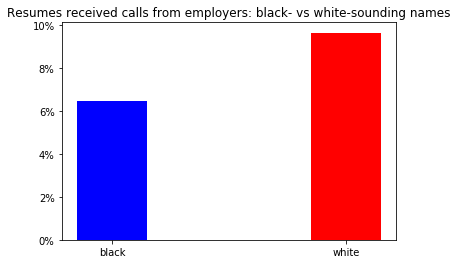

In [37]:
x = [1, 2]
y = [theta_b, theta_w]

plt.bar(x, y, width=0.3, color=['b','r'], tick_label=['black', 'white'])
plt.title('Resumes received calls from employers: black- vs white-sounding names')
# Convert ylabels to %
plt.gca().set_yticklabels(['{:.0f}%'.format(t*100) for t in plt.gca().get_yticks()])
plt.show()

<div class="span5 alert alert-success">
<p>Let $\theta$ be the proportion of resumes being called. The observed difference between $\theta_b$ and $\theta_w$ from the dataset is -3.2%. </p>

<p>Is this -3.2% by chance?</p>
<p>The confidence interval plot below shows that within 95% confidence interval, $\theta_b$ - $\theta_w$ is below zero. 
</div>

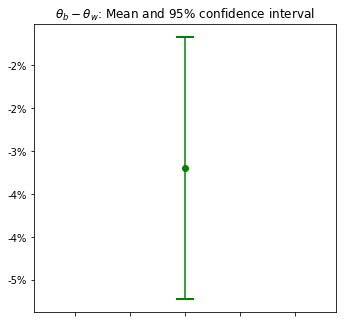

In [66]:
ax2 = plt.axes([0.85, 0.5, 0.7, 1])
plt.errorbar(x=1, y=theta_diff, yerr = ME, fmt='og', capsize=9, capthick=2)
plt.title(r'$\theta_b - \theta_w$: Mean and 95% confidence interval')
plt.ylim = [0, -0.06]
plt.gca().set_yticklabels(['{:.0f}%'.format(t*100) for t in plt.gca().get_yticks()])
ax2.set_xticklabels([])
plt.show()

<div class="span5 alert alert-success">
<p>The figure below shows the comparison between the observed difference (vertical line) and the histogram of simulated bootstrap difference assuming no distinction between black- and white-sounding names. The vertical line is very far away from the histogram, with no overlapping at all. This means that the vertical line, i.e., -3.2%, is not by chance. </p>
<p>Therefore we can conclude that the race plays a role in whether a candidate receives phone calls from potential employer or not. 
</div>

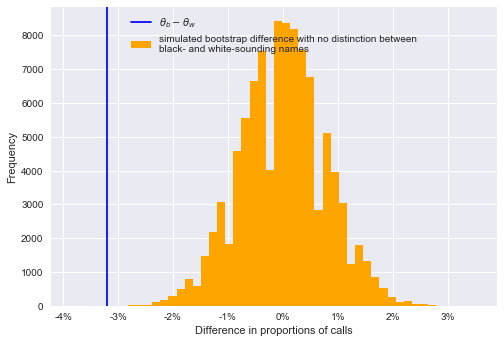

In [105]:
plt.hist(theta_diff_star, bins=50, color='orange')
plt.axvline(theta_diff, color = 'b')
plt.legend([r'$\theta_b - \theta_w$', 'simulated bootstrap difference with no distinction between\n\
black- and white-sounding names'], loc=9)
plt.gca().set_xticklabels(['{:.0f}%'.format(t*100) for t in plt.gca().get_xticks()])
plt.xlabel('Difference in proportions of calls')
plt.ylabel('Frequency')
plt.show()

## Q5.
Does your analysis mean that race/name is the most important factor in callback success? Why or why not? If not, how would you amend your analysis?

<div class="span5 alert alert-success">
<p>From the above analysis, it can be concluded that the race/name has significant effect on the callback success. However, it is insufficient to say that it is the most important factor, as there are other factors/features that have not been taken into account, such as education, years of experience. 

In order to answer this question, individual hypothesis tests can be performed for each of the factors and compare the magnitude of the p-values. However, this approach is tedious, as there are many features/factors in this dataset. A superior approach is to perform some feature selection, examples are:</p>

<p>
1. Chi Square Test. </p>
<p>2. Machine learning algorithms such as Lasso Regression or Ridge Regression, which can identify feature(s) that contribute most to the accuracy of the model. </p>






</div>